In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]
y = data_file["labels"]
y[y == "healthy"] = 0
y[y == "unhealthy"] = 1
y = y.astype(np.float32)

Removing trolls, shreks and duplicates


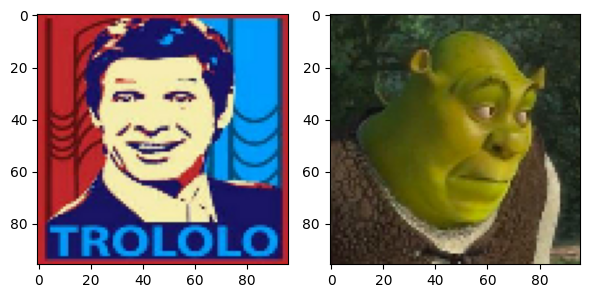

In [5]:
print("Removing trolls, shreks and duplicates")
initialDataN = data.shape[0]


troll = data[338]
shrek = data[58]


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(troll / 255)
axes[1].imshow(shrek / 255)
plt.tight_layout()
plt.show()

In [6]:
mask = []
for i in range(data.shape[0]):
    if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
        mask.append(False)
    else:
        mask.append(True)
data = data[mask]
y = y[mask]

In [7]:
data, indexes = np.unique(data, axis=0, return_index=True)
y = y[indexes]

print("Removed Images: " + str(initialDataN - data.shape[0]))

Removed Images: 350


In [8]:
y = tfk.utils.to_categorical(y, num_classes=2)

In [9]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [10]:
model.trainable = False

data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomZoom(0.1),
    tfkl.RandomBrightness(0.2),
    tfkl.RandomContrast(0.2),
])

inputs = tfk.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)

scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
x = scale_layer(x)

x = model(x, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)

output = tfkl.Dense(2, activation="softmax")(x)
tl_model = tfk.Model(inputs, output)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

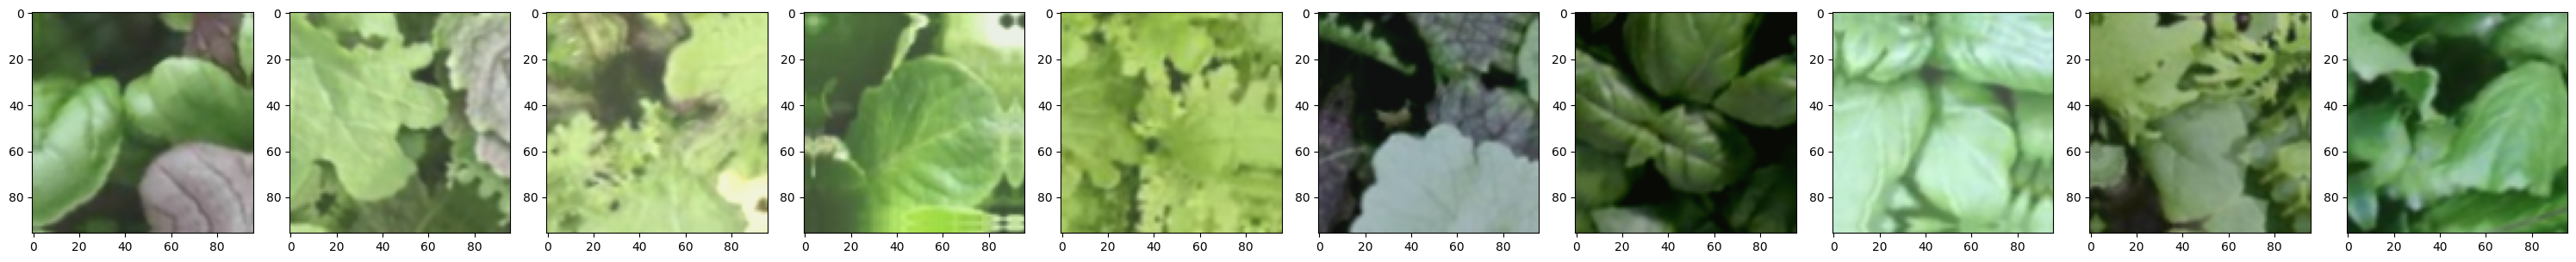

In [11]:
X_aug = data_augmentation(data)
fig, axes = plt.subplots(1, 10, figsize=(30, 3))
for i in range(10):
    axes[i].imshow(X_aug[i] / 255)
plt.tight_layout()
plt.show()

In [12]:
# Train the model
tl_history = tl_model.fit(
    x = data, # We need to apply the preprocessing
    y = y,
    batch_size = 16,
    epochs = 30,
).history

Epoch 1/30
304/304 [==============================] - 13s 29ms/step - loss: 0.5998 - accuracy: 0.6858
Epoch 2/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5504 - accuracy: 0.7252
Epoch 3/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5362 - accuracy: 0.7396
Epoch 4/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5183 - accuracy: 0.7526
Epoch 5/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5211 - accuracy: 0.7538
Epoch 6/30
304/304 [==============================] - 9s 28ms/step - loss: 0.5142 - accuracy: 0.7518
Epoch 7/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5142 - accuracy: 0.7561
Epoch 8/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5034 - accuracy: 0.7573
Epoch 9/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5154 - accuracy: 0.7598
Epoch 10/30
304/304 [==============================] - 8s 28ms/step - loss: 0.5212 - accur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


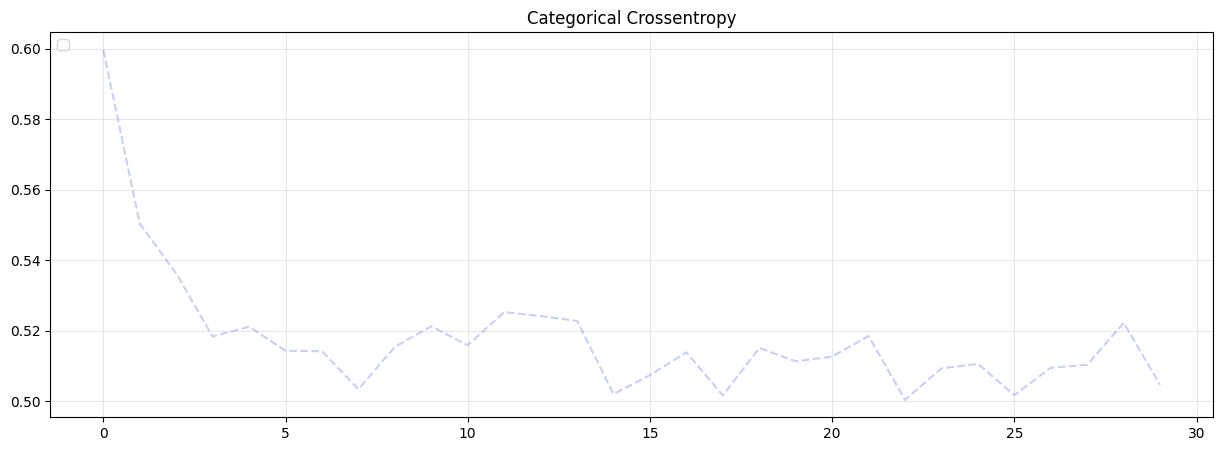

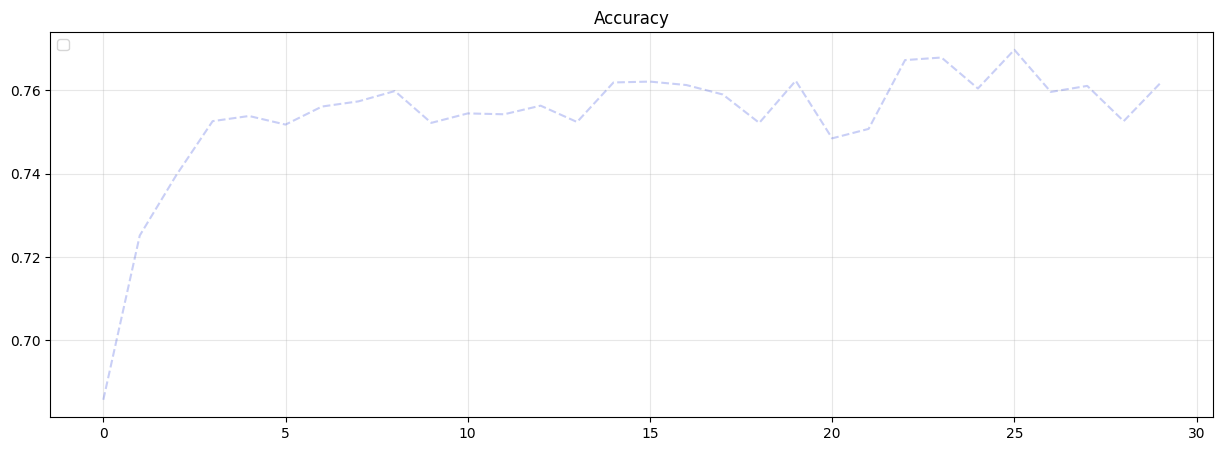

In [13]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [14]:
# Save the best model
tl_model.save('FullModel_TL')
del tl_model

In [15]:
ft_model = tf.keras.models.load_model('FullModel_TL')

In [16]:
ft_model.get_layer('xception').trainable = True

In [17]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])


In [18]:
ft_history = ft_model.fit(
    x = data, # We need to apply the preprocessing
    y = y,
    batch_size = 16,
    epochs = 100,
).history

Epoch 1/100
304/304 [==============================] - 52s 105ms/step - loss: 0.4704 - accuracy: 0.7769
Epoch 2/100
304/304 [==============================] - 32s 104ms/step - loss: 0.4235 - accuracy: 0.8089
Epoch 3/100
304/304 [==============================] - 32s 104ms/step - loss: 0.3918 - accuracy: 0.8212
Epoch 4/100
304/304 [==============================] - 32s 104ms/step - loss: 0.3599 - accuracy: 0.8328
Epoch 5/100
304/304 [==============================] - 32s 104ms/step - loss: 0.3405 - accuracy: 0.8470
Epoch 6/100
304/304 [==============================] - 32s 104ms/step - loss: 0.3221 - accuracy: 0.8616
Epoch 7/100
304/304 [==============================] - 32s 104ms/step - loss: 0.3137 - accuracy: 0.8629
Epoch 8/100
304/304 [==============================] - 31s 103ms/step - loss: 0.2808 - accuracy: 0.8792
Epoch 9/100
304/304 [==============================] - 32s 104ms/step - loss: 0.2862 - accuracy: 0.8713
Epoch 10/100
304/304 [==============================] - 31s 104m

In [19]:
# Save the best model
ft_model.save('FullModel_FT')
del ft_model

: 